# Coastal Erosion Case Study

### Background
Over 40% of the world’s population lives within 100 km of the coastline. However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

### The Problem
Monitoring coastlines and rivers using field surveys can be challenging and hazardous, particularly at regional or national scale. Aerial photography and LiDAR can be used to monitor coastal change, but this is often expensive and requires many repeated flights over the same areas of coastline to build up an accurate history of how the coastline has changed across time.

### Digital Earth Australia use case
Imagery from satellites such as the NASA/USGS Landsat program is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring coastlines and rivers at regional or national scale. By identifying and extracting the precise boundary between water and land based on satellite data, it is possible to extract accurate shorelines that can be compared across time to reveal hotspots of erosion and coastal change.

The usefulness of satellite imagery in the coastal zone can be affected by the presence of clouds, sun-glint over water, poor water quality (e.g. sediment) and the influence of tides. The effect of these factors can be reduced by combining individual noisy images into cleaner "summary" or composite layers, and filtering the data to focus only on images taken at certain tidal conditions (e.g. high tide). 

In this example, we combine data from the Landsat 5, 7 and 8 satellites with image compositing and tide filtering techniques to accurately map shorelines across time, and identify areas that have changed significantly between 1988 and 2018. The worked example takes users through the code required to:

1.  Load in a cloud-free Landsat time series
2.  Compute a water index (MNDWI)
3.  Filter images by tide height
4.  Create "summary" or composite images for given time periods
5.  Extract and visualise shorelines across time

### Technical details

* Products used: `ga_ls5t_ard_3`, `ga_ls7e_ard_3`, `ga_ls8c_ard_3`
* Bands used: `red`, `green`, `blue` and `swir1`. You can read more about the bands available for Landsat [here](https://landsat.gsfc.nasa.gov/landsat-8/landsat-8-bands/)
* Analyses used: MNDWI water index, tide modelling, image compositing, waterline extraction

**To run this analysis, run all the cells in the notebook, starting with the "Load modules" cell. When you finished the analysis, you can return to the "Set up analysis" cell, modify some values (e.g. choose a different location, time, tide height range or time period to analyse) and re-run the analysis. There are additional instructions on modifying the notebook at the end.**

## Load modules

In [1]:
import datacube
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import waterline_funcs
from utils.display import display_map

## Set up analysis

The following lines allow us to set up our analysis by selecting the location (`lat_range` and `lon_range`) and time (`time_range`) we want to investigate. We can also set two other important parameters: `tide_range` allows us to extract shorelines based on satellite images taken only at certain part of the tide range (e.g. at low or high tide). This can be useful for seperating the effect of erosion from the influence of tides. Finally, the `time_step` parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc:

* **lat_range:** The latitude range to analyse (e.g. `(-12.20, -12.27)`). For fast load times, keep this to a range of ~0.1 degrees or less.

* **lon_range:** The longitude range to analyse (e.g. `(131.80, 131.91)`). For fast load times, keep this to a range of ~0.1 degrees or less.

* **time_range:** The date range to analyse (e.g. `('2013-01-01', '2018-12-31') `)

* **time_step:** The time period to compare coastline change. `1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.

* **tide_range:** The lowest and highest tide heights to include in the analysis (e.g. `(0.00, 1.40)` in metre units). This will remove all images with tides outside this range from the dataset, allowing you to produce shorelines for specific tidal conditions (e.g. low tide, average tide, high tide etc)


### Edit these lines to change any of the analysis parameters

If you're running this notebook for the first time, we recommend you keep the default settings below. This will allow you to understand how the analysis works.

The example we've selected looks at coastal change in the Jumpinpin Channel between North and South Stradbroke Islands in south-eastern Queensland. **To change the location**, you'll need to make sure Landsat 5, 7 and 8 data is available for the new location, which you can check at the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all Landsat products). 

Run the following cell to set values for the various parameters discussed above.

In [2]:
lat_range = (-27.715, -27.755)
lon_range = (153.42, 153.46) 
time_range = ('1988', '2018') 
time_step = '2Y'
tide_range = (0.00, 1.40)

### View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [3]:
display_map(latitude=lat_range, longitude=lon_range)

## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. The code below first connects to the datacube database, and then uses the `load_cloudmaskedlandsat` function to load in data from the Landsat 5, 7 and 8 satellites for the area and time included in `lat_range`, `lon_range` and `time_range`. The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [4]:
# Connect to the datacube
# dc = datacube.Datacube(app='Coastal erosion')
dc = datacube.Datacube(env='c3-samples')

# Create the 'query' dictionary object, which contains the longitudes, latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'output_crs': 'EPSG:28356',
    'resolution': (-30, 30)
}

# Load satellite data for all Landsat satellites (5, 7 and 8) from 1987 onward
landsat_ds = waterline_funcs.load_cloudmaskedlandsat(dc, query, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_swir_1'])

print(landsat_ds)

<xarray.Dataset>
Dimensions:  (time: 950, x: 133, y: 149)
Coordinates:
  * y        (y) float64 6.934e+06 6.934e+06 6.934e+06 ... 6.93e+06 6.93e+06
  * x        (x) float64 5.414e+05 5.414e+05 5.415e+05 ... 5.453e+05 5.454e+05
  * time     (time) datetime64[ns] 1988-01-01T23:10:57.786457 ... 2018-12-29T23:37:24.903205
Data variables:
    red      (time, y, x) float64 dask.array<shape=(950, 149, 133), chunksize=(1, 149, 133)>
    green    (time, y, x) float64 dask.array<shape=(950, 149, 133), chunksize=(1, 149, 133)>
    blue     (time, y, x) float64 dask.array<shape=(950, 149, 133), chunksize=(1, 149, 133)>
    swir1    (time, y, x) float64 dask.array<shape=(950, 149, 133), chunksize=(1, 149, 133)>
Attributes:
    crs:      EPSG:28356


### Plot example timestep in true colour
To verify that we extracted data for the area we're interested in analysing, we can plot up the first image in the dataset in true colour. This makes use of the `red`, `green` and `blue` Landsat bands that we loaded in the previous cell.

Change `index=0` to another value (e.g. `index=1`) to plot up different timesteps. You should be able to clearly see where clouds have been masked out.

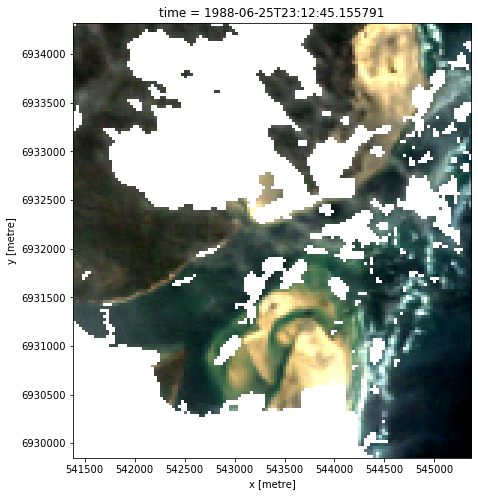

In [9]:
waterline_funcs.rgb(landsat_ds, index=10, size=8)

## Compute Modified Normalised Difference Water Index
To extract shoreline locations, we need to be able to seperate water from land in our study area. To do this, we can use our Landsat data to calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI. This index uses the ratio of green and mid-infrared radiation to identify the presence of water. You can find more information on it in the [original research article](http://www.aari.ru/docs/pub/060804/xuh06.pdf). The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(Green - MIR)}{(Green + MIR)}
\end{aligned}
$$

where `Green` is the green band and `MIR` is the mid-infrared band. For Landsat, we can use the Short-wave Infrared (SWIR) 1 band as our measure for `MIR`.

When it comes to interpreting the index, **High values (greater than 0, blue colours) typically represent water pixels**, while **low values (less than 0, red colours) represent land**. You can use the cell below to calculate and plot one of the images after calculating the index.

In [ ]:
landsat_ds['water_index'] = ((landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1))
landsat_ds.water_index.isel(time=10).plot(cmap='RdBu', size=6, vmin=-0.8, vmax=0.8)
plt.show()

How does the plot of the index compare to the optical image from earlier? Was there water or land anywhere you weren't expecting?

## Calculate tide heights
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to reduce the effect of tides by modelling tide height data, and keeping only the satellite images that were taken at specific tidal conditions. For example, if `tide_range = (0.00, 1.40)`, we are telling the analysis to focus only on satellite images taken when the tide was between `0.00 m` and `1.40 m` relative to Mean Sea Level.

The `tidal_tag` function below uses the [OTPS TPXO9 tidal model](http://volkov.oce.orst.edu/tides/global.html) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new `tide_height` attribute in our dataset.

In [ ]:
landsat_ds = waterline_funcs.tidal_tag(ds=landsat_ds)
print(landsat_ds)

Now that we have modelled tide heights, we can plot them to visualise the range of tide that was captured by Landsat across our time series. In the plot below, red dashed lines also show the subset of the tidal range we selected using the `tide_range` parameter. The plot should make it clear that limiting the range of the tides for the analysis should give you more consistent results. A large variance in the tide height could obscure your results, so consistency is critical as you want to compare the change in the shoreline from year to year.

In [ ]:
# Plot the resulting tide heights for each Landsat image:
landsat_ds.tide_height.plot()
plt.axhline(tide_range[0], c='red', linestyle='--')
plt.axhline(tide_range[1], c='red', linestyle='--')
plt.show()

### Filter Landsat images by tide height
Here we take the Landsat dataset and only keep the images with tide heights we want to analyse (i.e. tides within the heights given by `tide_range`). This will result in a smaller number of images (e.g. ~500 images compared to ~900):

In [ ]:
landsat_filtered = landsat_ds.where((landsat_ds.tide_height > tide_range[0]) & 
                                    (landsat_ds.tide_height < tide_range[1]), drop=True)
print(landsat_filtered)

## Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, including clouds, sunglint and poor water quality conditions (e.g. sediment). To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers (like masked cloud values) from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset. This step can take **several minutes to load** if the study area is large.

In [ ]:
# Combine by time
landsat_summaries = landsat_filtered.water_index.compute().resample(time=time_step).median('time')
landsat_summaries.plot(col='time', cmap='RdBu', col_wrap=4, vmin=-0.8, vmax=0.8)
plt.show()

## Extract shorelines from imagery
We now want to extract an accurate shoreline for each each of the summary images above (e.g. 1987, 1989 etc. summaries). The code below identifies the boundary between land and water by tracing a line along pixels with a water index value of `0` (halfway between land and water water index values). It returns a shapefile with one line for each time step:


In [ ]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in landsat_summaries.time.values]}
attribute_dtypes = {'time': 'str'}

# Extract waterline contours for the '0' water index threshold:
contour_gdf = waterline_funcs.contour_extract(
    z_values=[0],
    ds_array=landsat_summaries,
    ds_crs=landsat_ds.crs,
    ds_affine=landsat_ds.geobox.transform,
    output_shp=f'output_waterlines.shp',
    attribute_data=attribute_data,
    attribute_dtypes=attribute_dtypes,
    min_vertices=50
)

# Plot output shapefile over the top of the earliest MNDWI layer
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
landsat_summaries.isel(time=0).plot(ax=ax, cmap='Greys')
contour_gdf.plot(ax=ax, cmap='YlOrRd')

The above plot is a basic visualisation of the contours returned by the `contour_extract` function. Given we now have the shapefile, we can use a more complex function to make an interactive plot for viewing the change in shoreline over time below.

### Plot interactive map of output shorelines coloured by time
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. Run it to view the map.

Zoom in to the map below to explore the resulting set of shorelines. Older shorelines are coloured in yellow; more recent shorelines in red. Using this data, we can easily identify areas of rivers or coastline that have changed significantly over time, or areas that have remained stable over the entire time period. This step can take **several minutes to load** if the study area is large.

In [ ]:
waterline_funcs.map_shapefile(gdf=contour_gdf)

## Drawing conclusions
Here are some questions to think about:
* What can you conclude about the change in the shoreline? 
* Which sections of the shoreline have seen the most change? 
* Is the change consistent with erosion? 
* What other information might you need to draw additional conclusions about the cause of the change?

## Next steps
When you are done, return to the "Set up analysis" cell, modify some values (e.g. `time_range`, `tide_range`, `time_step` or `lat_range`/`lon_range`) and rerun the analysis. For example, to run the same analysis on the Gold Coast beaches near the NSW/Queensland border, you could try the following values:
```
lat_range = (-28.16, -28.18)
lon_range = (153.52, 153.56) 
time_range = ('1988', '2018') 
time_step = '2Y'
tide_range = (0.00, 1.40)
```
If you're going to change the location, you'll need to make sure Landsat 5, 7 and 8 data is available for the new location, which you can check at the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all Landsat products). 

## Further exploration
While this notebook mostly utilised the functions available from the Open Data Cube library, some of the steps were conducted with functions from the `waterline_funcs` module, which you can find in the `utils` folder. If you're curious about how these functions work, feel free to explore the `utils/waterline_funcs.py` file. This option is for users who feel comfortable programming in Python. You'll be able to navigate to this file from the Jupyter file explorer page.